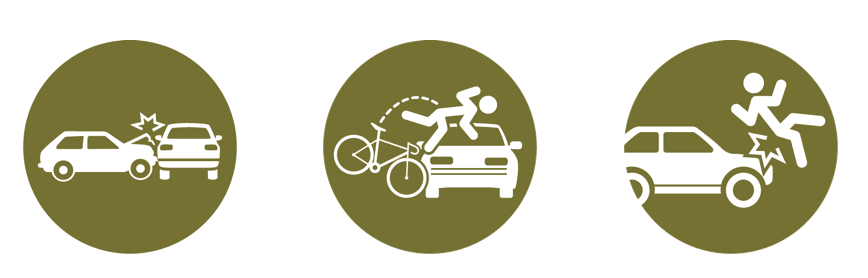

In [2]:
from IPython.display import HTML
from IPython.display import Image
import webbrowser

Image("CrashIcon.png")

# Crash Data Week 4 (Bruce)


Our goal is to predict "number of car crashes with injuries for each month of the year 2016". We use Oregon Department of Transportation auto collision data from 2003 to 2014 to train two predictive time-series models. Then we predict monthly crashes for 2015 and use 2015 actual data to evaluate and improve the model. Finally, we use the updated models (along with the 2015 data) to predict monthly crashes-with-injuries for 2016.

Our first model is a simple linear regression model that fits a least-squares regression line to the training data. The second model is a Generalized Additive Model (GAM) as implemented by the Facebook package Prophet.

During the first three meetings of the four-week meetup session we explored the data and used various data wrangling techniques to prepare the data for analysis.  The full ODOT auto collision data set contains more than 100 attributes for each collision. To speed this week's computations we pre-processed the 2003-2015 data set into simplified .csv files containing just two columns, a datestamp column and a 'y' column containing counts of crashes with injuries for each date. This simplification greatly reduces the data and computation required for the modeling.

All input data was provided by the Oregon Department of Transportation.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
 
# Force plots to be wider than the default
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

# we list out all of the years like this to allow easy selection and update of the input data
years = [2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015]
yeardfs = []
datadir = './data'

for year in years:
    filename = datadir+"/"+"Counts_"+str(year)+".csv"
    ydata = pd.read_csv(filename, low_memory=False)
    if (year == 2007):
        # this bit of data cleaning is needed because the 2007 data appears to be distorted by a factor of 2
        ydata.loc[ydata['y'] > 0, 'y'] /= 2
    yeardfs.append(ydata)

# combine all of the years into a single DataFrame
df = pd.concat(yeardfs)
print(str(df.shape[0]),"days with crashes between",years[0],"and",years[-1])


4748 days with crashes between 2003 and 2015


In [4]:
df.head(n=5)

,Unnamed: 0,y,ds
0,0,21.0,2003-01-01
1,1,57.0,2003-01-02
2,2,70.0,2003-01-03
3,3,46.0,2003-01-04
4,4,40.0,2003-01-05


In [5]:
df.sort_values('ds',inplace=True)
df.tail(n=10)

,Unnamed: 0,y,ds
355,355,108.0,2015-12-22
356,356,129.0,2015-12-23
357,357,99.0,2015-12-24
358,358,36.0,2015-12-25
359,359,46.0,2015-12-26
360,360,52.0,2015-12-27
361,361,61.0,2015-12-28
362,362,75.0,2015-12-29
363,363,120.0,2015-12-30
364,364,78.0,2015-12-31


In [6]:
# resample the daily data into monthly bins
mon_df = df.set_index(pd.DatetimeIndex(df['ds']))
mon_df = mon_df.resample('M').sum()
print("After resample we have",mon_df.shape[0],"months")
mon_df.head(n=12)


After resample we have 156 months


,Unnamed: 0,y
ds,,
2003-01-31,465,1753.0
2003-02-28,1246,1337.0
2003-03-31,2294,1298.0
2003-04-30,3135,1615.0
2003-05-31,4185,1629.0
2003-06-30,4965,1576.0
2003-07-31,6076,1711.0
2003-08-31,7037,1686.0
2003-09-30,7725,1606.0


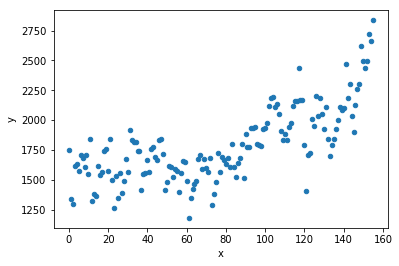

In [7]:
# a scatter plot helps to sanity check the data
plotdf = mon_df.reset_index()

# have not quite mastered pandas' handling of columns and indexes
# this bit of hacky code cleans up my columns
plotdf.columns = ['ds', 'tobedropped', 'y']
plotdf.drop(columns=['tobedropped'], inplace=True)
plotdf.reset_index(inplace=True)
plotdf.columns = ['x','ds', 'y']

plotdf.plot(kind="scatter",x='x',y='y')

## Prediction Method 1
least-squares linear regression model using numpy.polyfit()

In [10]:
# Prediction Method #1: a least-squares linear regression model

import numpy as np

polyfit = np.polyfit(x=plotdf.loc[:, 'x'], y=plotdf.loc[:, 'y'], deg=1)
p = np.poly1d(polyfit)

print("Least squares best fit line equation:", p)


Least squares best fit line equation:  
5.04 x + 1402


[(0, 2500)]

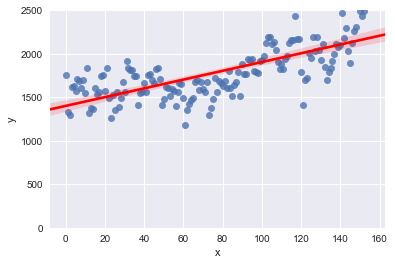

In [11]:
# sanity check the model by showing it super-imposed over the actual data
import seaborn as sns; sns.set(color_codes=True)
ax = sns.regplot(x="x", y="y", data=plotdf, line_kws={"color": "red"})
ax.set(ylim=(0, 2500))


In [12]:
# next, compute the predictions for the following 12 months
pyear = years[-1]+1
sdate = "1/1/"+str(pyear)
edate = "12/31/"+str(pyear)

drange = pd.date_range(start=sdate, end=edate, freq='M')

predf = plotdf
x = predf.shape[0]

m = polyfit[0]
b = polyfit[1]

for date in drange:
    pred_y = round((m * x) + b)  
    predf = predf.append({'x':x, 'ds':date, 'y':pred_y}, ignore_index=True)
    x = x + 1
    
predf.tail(n=13)

,x,ds,y
155,155,2015-12-31,2836.0
156,156,2016-01-31,2188.0
157,157,2016-02-29,2193.0
158,158,2016-03-31,2198.0
159,159,2016-04-30,2203.0
160,160,2016-05-31,2208.0
161,161,2016-06-30,2213.0
162,162,2016-07-31,2218.0
163,163,2016-08-31,2223.0
164,164,2016-09-30,2228.0


[(0, 2500)]

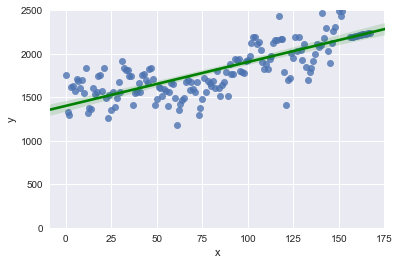

In [13]:
# sanity check the prediction with a visualization
# the 12 new values should appear on the righthand end of the prediction line
ax = sns.regplot(x="x", y="y", data=predf, line_kws={"color": "green"})
ax.set(ylim=(0, 2500))

## Prediction Method 2
Generalized Addtive Model using Facebook Prophet package

In [14]:
# this modeling performs best when used at the daily granularity
# so we make our forecast at the daily level and downsample it to monthly

from fbprophet import Prophet
m = Prophet(daily_seasonality=True)

import warnings 
with warnings.catch_warnings(): 
    warnings.filterwarnings("ignore",category=FutureWarning)
    m.fit(df)

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# the yhat column contains the prediction, yhat_{lower,upper} give a 95% (I believe) confidence interval



,ds,yhat,yhat_lower,yhat_upper
5108,2016-12-26,86.019645,69.788599,100.925321
5109,2016-12-27,88.505655,72.917385,104.450340
5110,2016-12-28,87.645822,72.409227,104.800975
5111,2016-12-29,87.334135,71.312508,103.764515
5112,2016-12-30,95.976928,79.406602,111.433711


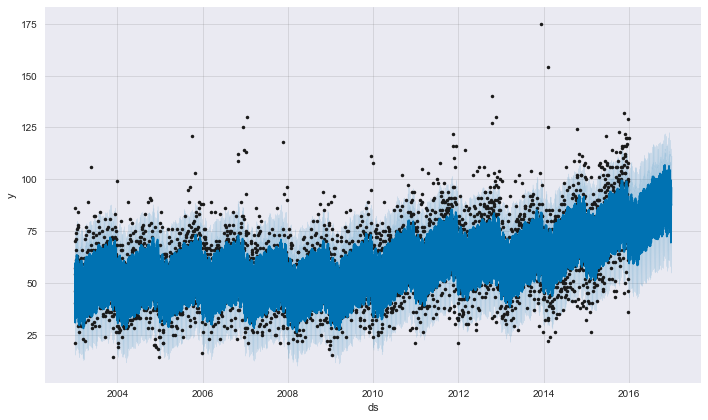

In [15]:
# the following plot looks cool, but I'm not really sure what it's worth
fig1 = m.plot(forecast)

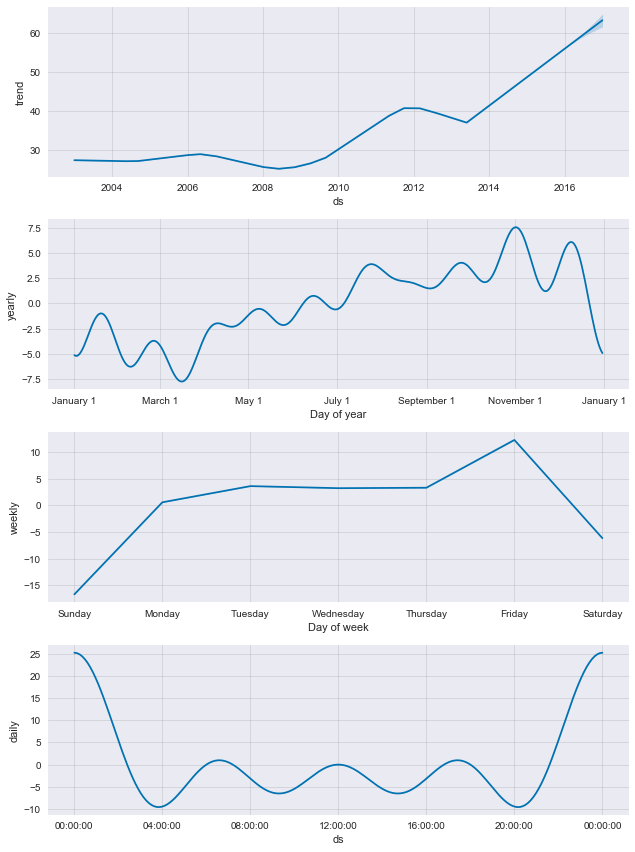

In [16]:
# plot the underlying component functions that make up the GAM
# this shows how effective Prophet is at teasing out 
# trends and patterns at the yearly, monthly, weekly and daily granularities 
#
# some comments and questions:
#  cool that it figures out that months like February (with fewer days) have fewer crashes
#  several of the bumps in the monthly calendar seem to be months with 31 days 
#  why the dip in 2013?
#  why so many crashes near the beginning of November? begin of rainy season?
#  don't drive on July 4!
#  don't drive on Fridays!
#  is the big midnight spike real or is it some sort of bookkeeping artifact?
#
# with more time and work we could tune prophet and add additional underlying functions
# (such as a listing of holidays on which we might suspect many/few crashes).
#  
fig2 = m.plot_components(forecast)

In [17]:
# get rid of all the other stuff that prophet computed
mon_fcst = forecast.filter(['ds','yhat'], axis=1)

# we want monthly predictions, so downsample the forecast to monthly
mon_fcst = mon_fcst.set_index(pd.DatetimeIndex(mon_fcst['ds']))
mon_fcst = mon_fcst.resample('M').sum().round()
mon_fcst = mon_fcst.reset_index()
mon_fcst.tail(n=12)

,ds,yhat
156,2016-01-31,2425.0
157,2016-02-29,2236.0
158,2016-03-31,2384.0
159,2016-04-30,2441.0
160,2016-05-31,2548.0
161,2016-06-30,2541.0
162,2016-07-31,2697.0
163,2016-08-31,2736.0
164,2016-09-30,2692.0
165,2016-10-31,2798.0


# Compare the Predictions

In [18]:
 # prepare the predictions so that they can be compared in a table
pred1 = predf.tail(n=12)
pred1 = pred1.reset_index()
    
pred2 = mon_fcst.tail(n=12)
pred2 = pred2.reset_index()

comparison = pd.DataFrame()
comparison['ds'] = pred1['ds']
comparison['pred1'] = pred1['y'].astype(int)
comparison['pred2'] = pred2['yhat'].astype(int)
    

In [19]:
# try to read the actual data so that we can compare the predictions to the actual data
import os.path

actual_year = years[-1]+1
fname = datadir+"/"+"Counts_"+str(actual_year)+".csv"

if (os.path.isfile(fname)):
    actual_data = pd.read_csv(fname, low_memory=False)
    print("read", actual_data.shape[0], "rows")
    
    # downsample to monthly values
    actual_data = actual_data.set_index(pd.DatetimeIndex(actual_data['ds']))
    actual_data = actual_data.resample('M').sum()
    actual_data = actual_data.reset_index()    
    comparison['actual'] = actual_data['y']
else:
    print("unable to compare predictions to actual data from year " + 
          str(actual_year) + " because file " + fname + " does not exist")

print(comparison)    

unable to compare predictions to actual data from year 2016 because file ./data/Counts_2016.csv does not exist
           ds  pred1  pred2
0  2016-01-31   2188   2425
1  2016-02-29   2193   2236
2  2016-03-31   2198   2384
3  2016-04-30   2203   2441
4  2016-05-31   2208   2548
5  2016-06-30   2213   2541
6  2016-07-31   2218   2697
7  2016-08-31   2223   2736
8  2016-09-30   2228   2692
9  2016-10-31   2233   2798
10 2016-11-30   2238   2748
11 2016-12-31   2243   2731
